In [2]:
# BÖLÜM 1: KÜTÜPHANELER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

file_name = "CDC_Wastewater_Data_for_Influenza_A.csv"
df = pd.read_csv(file_name, low_memory=False)


In [3]:
# BÖLÜM 2: VERİ ÖN İŞLEME VE ÖZELLİK MÜHENDİSLİĞİ (FEATURE ENGINEERING)
print("--- Veri Temizliği ve Özellik Mühendisliğine Başlanıyor ---")

df['sample_collect_date'] = pd.to_datetime(df['sample_collect_date'], errors='coerce')
df['collection_month'] = df['sample_collect_date'].dt.month
df['collection_week'] = df['sample_collect_date'].dt.isocalendar().week.astype(int)
df['collection_dayofweek'] = df['sample_collect_date'].dt.dayofweek

print("Adım (Yeni FE): Döngüsel zaman özellikleri (sin/cos) oluşturuluyor...")
df['month_sin'] = np.sin(2 * np.pi * df['collection_month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['collection_month'] / 12)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['collection_dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['collection_dayofweek'] / 7)

df['flow_rate_missing'] = df['flow_rate'].isnull().astype(int)
flow_median = df['flow_rate'].median()
df['flow_rate'] = df['flow_rate'].fillna(flow_median)

df['pcr_target_flowpop_lin'] = df['pcr_target_flowpop_lin'].fillna(df['pcr_target_flowpop_lin'].median())
df['flowpop_lin_missing'] = df['pcr_target_flowpop_lin'].isnull().astype(int)

df['log_population_served'] = np.log1p(df['population_served'])
df['log_flow_rate'] = np.log1p(df['flow_rate'])

df['influenza_a_detected'] = (df['pcr_target_avg_conc'] > 0).astype(int)
df['log_pcr_target_conc'] = np.log1p(df['pcr_target_avg_conc'])

print("Adım (Yeni FE): Etkileşim özelliği (Kişi Başına Logaritmik Yük) oluşturuluyor...")
df['log_conc_per_capita'] = df['log_pcr_target_conc'] - df['log_population_served']
df['log_conc_per_capita'] = df['log_conc_per_capita'].replace([np.inf, -np.inf], 0)

bins = [0, 20000, 50000, 200000, np.inf]
labels = ['Small', 'Medium', 'Large', 'Very Large']
df['population_group'] = pd.cut(df['population_served'], bins=bins, labels=labels, right=False)

print("Adım (Yeni FE): Kategori Sıklık Kodlaması (Frequency Encoding) oluşturuluyor...")
jurisdiction_counts = df['wwtp_jurisdiction'].value_counts()
df['jurisdiction_freq'] = df['wwtp_jurisdiction'].map(jurisdiction_counts).fillna(0)

columns_to_drop = [
    'inhibition_adjust', 'sample_id', 'date_updated', 'rec_eff_target_name',
    'rec_eff_spike_matrix', 'rec_eff_spike_conc', 'hum_frac_mic_unit',
    'pcr_target_mic_lin', 'hum_frac_mic_conc', 'hum_frac_target_mic',
    'ntc_amplify'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

df['pasteurized'] = df['pasteurized'].fillna(df['pasteurized'].mode()[0])
df['counties_served'] = df['counties_served'].fillna(df['counties_served'].mode()[0])
df['lod_sewage'] = df['lod_sewage'].fillna(df['lod_sewage'].median())
df['pcr_gene_target_agg'] = df['pcr_gene_target_agg'].fillna(df['pcr_gene_target_agg'].mode()[0])
df['rec_eff_percent'] = np.clip(df['rec_eff_percent'], a_min=None, a_max=100)

df.drop_duplicates(inplace=True)

print("Adım (Encoding): 'population_group' (Small, Medium...) için 'population_group_encoded' (0, 1, 2...) sütunu ekleniyor...")
pop_kategorileri = pd.CategoricalDtype(
    categories=['Small', 'Medium', 'Large', 'Very Large'],
    ordered=True
)
df['population_group'] = df['population_group'].astype(pop_kategorileri)
df['population_group_encoded'] = df['population_group'].cat.codes

print("--- Veri Temizliği ve Özellik Mühendisliğine Tamamlandı ---")


--- Veri Temizliği ve Özellik Mühendisliğine Başlanıyor ---
Adım (Yeni FE): Döngüsel zaman özellikleri (sin/cos) oluşturuluyor...
Adım (Yeni FE): Etkileşim özelliği (Kişi Başına Logaritmik Yük) oluşturuluyor...
Adım (Yeni FE): Kategori Sıklık Kodlaması (Frequency Encoding) oluşturuluyor...
Adım (Encoding): 'population_group' (Small, Medium...) için 'population_group_encoded' (0, 1, 2...) sütunu ekleniyor...
--- Veri Temizliği ve Özellik Mühendisliğine Tamamlandı ---



--- Keşifsel Analizin (EDA) Ana Grafik Çıktıları ---


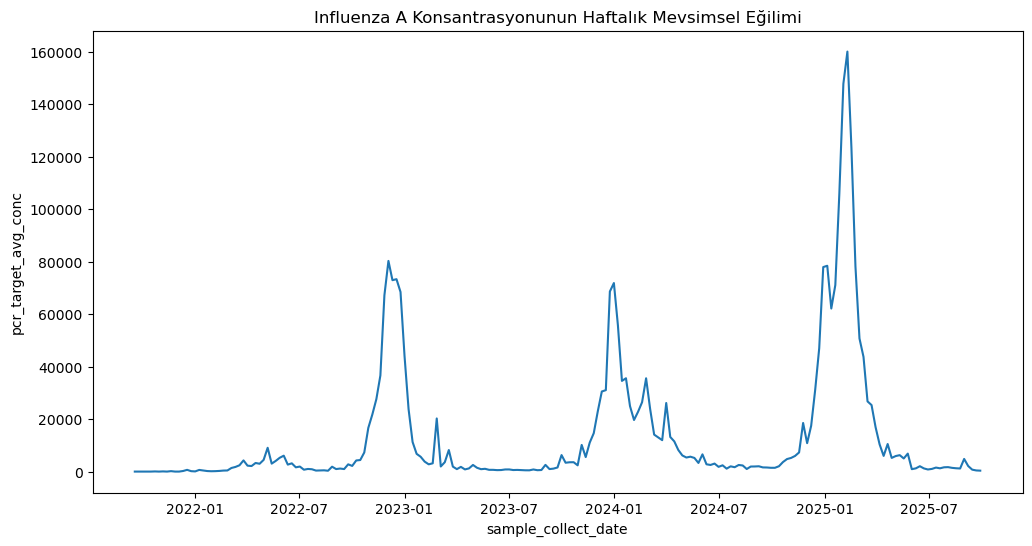

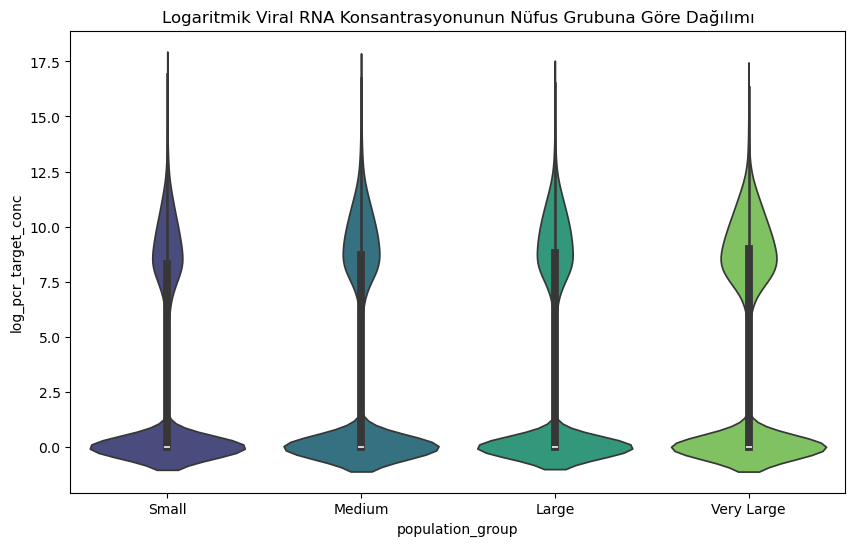


Temizlenmiş ve (YENİ ÖZELLİKLERİ) içeren veri seti başarıyla kaydedildi: temizlenmis_veri_seti_FINAL_koddan_olustu.csv


In [4]:
# BÖLÜM 3: KEŞİFSEL VERİ ANALİZİ (EDA) VE KAYIT
print("\n--- Keşifsel Analizin (EDA) Ana Grafik Çıktıları ---")

plt.figure(figsize=(12, 6))
weekly_avg = df.dropna(subset=['sample_collect_date']).set_index('sample_collect_date')['pcr_target_avg_conc'].resample('W').mean().reset_index()
sns.lineplot(data=weekly_avg, x='sample_collect_date', y='pcr_target_avg_conc')
plt.title('Influenza A Konsantrasyonunun Haftalık Mevsimsel Eğilimi')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(
    x=df['population_group'].astype(str), y='log_pcr_target_conc', data=df,
    order=['Small', 'Medium', 'Large', 'Very Large'], palette='viridis',
    hue=df['population_group'].astype(str), legend=False
)
plt.title('Logaritmik Viral RNA Konsantrasyonunun Nüfus Grubuna Göre Dağılımı')
plt.show()


output_file_name = "temizlenmis_veri_seti_FINAL_koddan_olustu.csv"
df.to_csv(output_file_name, index=False)
print(f"\nTemizlenmiş ve (YENİ ÖZELLİKLERİ) içeren veri seti başarıyla kaydedildi: {output_file_name}")

In [5]:
# BÖLÜM 4: SINIFLANDIRMA MODELİ HAZIRLIĞI (SPLIT, SCALE, PCA)
features = [
    'collection_week',
    'log_population_served', 'log_flow_rate', 'rec_eff_percent',
    'flow_rate_missing', 'flowpop_lin_missing',
    'population_group_encoded',
    'month_sin', 'month_cos',
    'dayofweek_sin', 'dayofweek_cos',
    'log_conc_per_capita',
    'jurisdiction_freq'
]

df_model = df.dropna(subset=features + ['influenza_a_detected', 'log_pcr_target_conc'])

X = df_model[features]

print(f"Model Eğitimi İçin Kullanılan Toplam Satır Sayısı (NaN'ler atıldıktan sonra): {X.shape[0]}")

print("\n--- BÖLUM 1: SINIFLANDIRMA MODELİ EĞİTİMİNE BAŞLANIYOR ---")

y_clf = df_model['influenza_a_detected']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print("\nAdım (PCA - Sınıflandırma): Ana Bileşen Analizi uygulanıyor...")
pca_clf = PCA(n_components=0.95, random_state=42)
X_train_clf_pca = pca_clf.fit_transform(X_train_clf_scaled)
X_test_clf_pca = pca_clf.transform(X_test_clf_scaled)
print(f"PCA (Sınıflandırma) {X_train_clf_scaled.shape[1]} adet orijinal özelliği {pca_clf.n_components_} adet ana bileşene indirdi.")

feature_names_clf_pca = [f'Ana Bileşen {i+1}' for i in range(pca_clf.n_components_)]


Model Eğitimi İçin Kullanılan Toplam Satır Sayısı (NaN'ler atıldıktan sonra): 212401

--- BÖLUM 1: SINIFLANDIRMA MODELİ EĞİTİMİNE BAŞLANIYOR ---

Adım (PCA - Sınıflandırma): Ana Bileşen Analizi uygulanıyor...
PCA (Sınıflandırma) 13 adet orijinal özelliği 9 adet ana bileşene indirdi.



--- MODEL 1.1 SONUÇLARI (SGD Sınıflandırıcısı - Ayarlanmış Parametreler ile) ---
Model Doğruluğu (Accuracy): 0.9999
Sınıflandırma Raporu:
               precision    recall  f1-score   support

Grip Yok (0)       1.00      1.00      1.00     24632
Grip Var (1)       1.00      1.00      1.00     17849

    accuracy                           1.00     42481
   macro avg       1.00      1.00      1.00     42481
weighted avg       1.00      1.00      1.00     42481

Model 1.1 - Karmaşıklık Matrisi (Metin):
 [[24632     0]
 [    3 17846]]


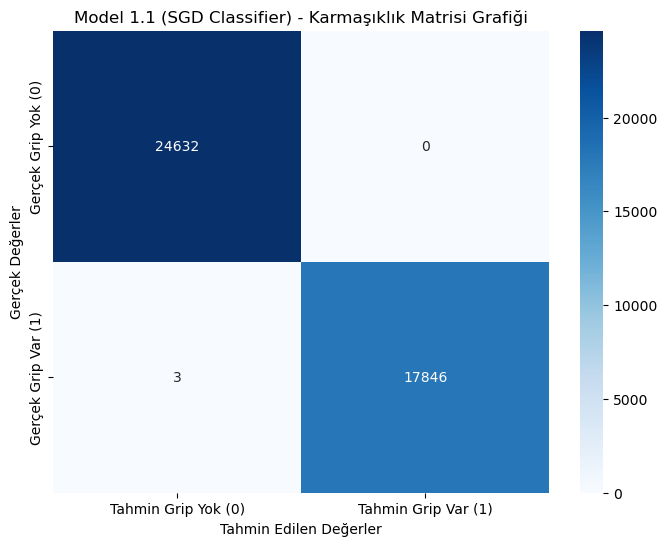


--- PCA Bileşenlerinin Yorumlanması (Sınıflandırma Modeli 1.1) ---
Grafikteki 'Ana Bileşenlerin' (PC) hangi orijinal özellikleri temsil ettiğini gösteren ana yükler (loadings):

Ana Bileşen 1:
  En çok etkileyen 3 özellik: ['log_population_served', 'population_group_encoded', 'log_flow_rate']

Ana Bileşen 2:
  En çok etkileyen 3 özellik: ['month_sin', 'collection_week', 'log_conc_per_capita']

Ana Bileşen 3:
  En çok etkileyen 3 özellik: ['rec_eff_percent', 'flow_rate_missing', 'log_flow_rate']

Ana Bileşen 4:
  En çok etkileyen 3 özellik: ['month_cos', 'log_conc_per_capita', 'collection_week']

Ana Bileşen 5:
  En çok etkileyen 3 özellik: ['dayofweek_sin', 'dayofweek_cos', 'rec_eff_percent']

Ana Bileşen 6:
  En çok etkileyen 3 özellik: ['jurisdiction_freq', 'flow_rate_missing', 'dayofweek_cos']

Ana Bileşen 7:
  En çok etkileyen 3 özellik: ['dayofweek_cos', 'dayofweek_sin', 'jurisdiction_freq']

Ana Bileşen 8:
  En çok etkileyen 3 özellik: ['rec_eff_percent', 'flow_rate_missing', 'l

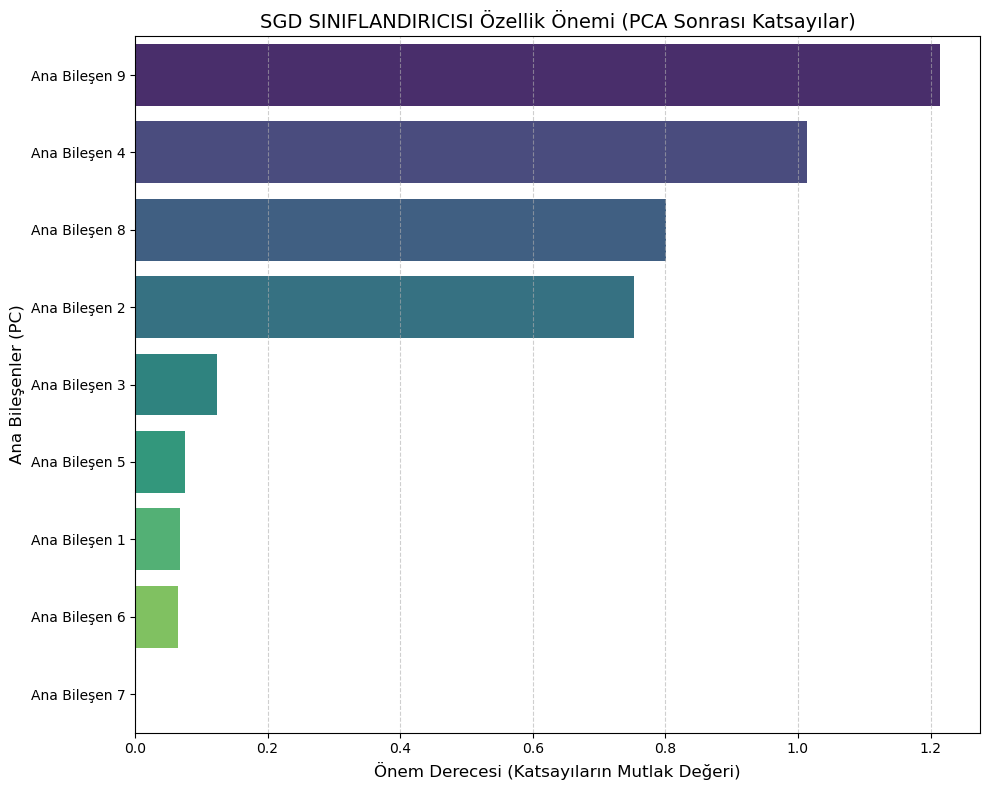


--- MODEL 1.2 SONUÇLARI (Karar Ağacı Sınıflandırıcısı - PCA ile) ---
Model Doğruluğu (Accuracy): 0.9990
Sınıflandırma Raporu:
               precision    recall  f1-score   support

Grip Yok (0)       1.00      1.00      1.00     24632
Grip Var (1)       1.00      1.00      1.00     17849

    accuracy                           1.00     42481
   macro avg       1.00      1.00      1.00     42481
weighted avg       1.00      1.00      1.00     42481

Model 1.2 - Karmaşıklık Matrisi (Metin):
 [[24611    21]
 [   22 17827]]


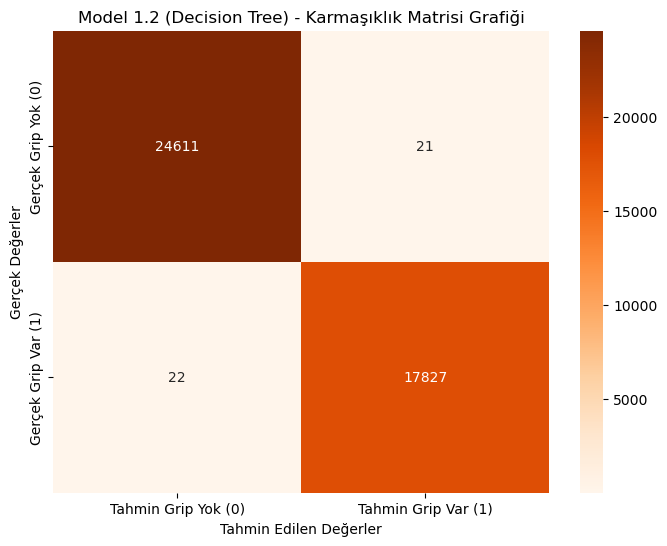

In [6]:
# BÖLÜM 5: SINIFLANDIRMA MODELLERİ (SGD ve DT - PCA İLE)
print("\n--- MODEL 1.1 SONUÇLARI (SGD Sınıflandırıcısı - Ayarlanmış Parametreler ile) ---")

model_sgd_clf = SGDClassifier(
    random_state=60,
    class_weight='balanced',
    loss='modified_huber',
    penalty='elasticnet',
    l1_ratio=0.15,
    alpha=0.001,
    n_jobs=-1
)
model_sgd_clf.fit(X_train_clf_pca, y_train_clf)
y_pred_sgd_clf = model_sgd_clf.predict(X_test_clf_pca)

print(f"Model Doğruluğu (Accuracy): {accuracy_score(y_test_clf, y_pred_sgd_clf):.4f}")
print("Sınıflandırma Raporu:\n", classification_report(y_test_clf, y_pred_sgd_clf, target_names=['Grip Yok (0)', 'Grip Var (1)']))

cm_sgd = confusion_matrix(y_test_clf, y_pred_sgd_clf)
print("Model 1.1 - Karmaşıklık Matrisi (Metin):\n", cm_sgd)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tahmin Grip Yok (0)', 'Tahmin Grip Var (1)'], 
            yticklabels=['Gerçek Grip Yok (0)', 'Gerçek Grip Var (1)'])
plt.title('Model 1.1 (SGD Classifier) - Karmaşıklık Matrisi Grafiği')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()


#  PCA Bileşen Yorumlaması (Sınıflandırma) 
print("\n--- PCA Bileşenlerinin Yorumlanması (Sınıflandırma Modeli 1.1) ---")
print("Grafikteki 'Ana Bileşenlerin' (PC) hangi orijinal özellikleri temsil ettiğini gösteren ana yükler (loadings):")
loadings_clf = pca_clf.components_

for i, component in enumerate(feature_names_clf_pca):
    weights = loadings_clf[i]
    feature_weights = pd.Series(weights, index=features)
    sorted_weights = feature_weights.abs().sort_values(ascending=False)
    top_features = sorted_weights.head(3).index
    
    print(f"\n{component}:")
    print(f"  En çok etkileyen 3 özellik: {list(top_features)}")
print("----------------------------------------------------------")

# SGD Sınıflandırıcı Özellik Önemi Grafiği (PCA ile)
print("\nAdım (Grafik): SGD Sınıflandırıcı Özellik Önemi (Katsayılar) gösteriliyor...")
feature_importances_sgd = np.abs(model_sgd_clf.coef_[0])
importance_df_sgd = pd.DataFrame({
    'Feature': feature_names_clf_pca,
    'Importance': feature_importances_sgd
}).sort_values(by='Importance', ascending=False)
top_features_sgd = importance_df_sgd.head(pca_clf.n_components_)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', y='Feature', data=top_features_sgd,
    palette='viridis',
    hue='Feature', legend=False
)
plt.title('SGD SINIFLANDIRICISI Özellik Önemi (PCA Sonrası Katsayılar)', fontsize=14)
plt.xlabel('Önem Derecesi (Katsayıların Mutlak Değeri)', fontsize=12)
plt.ylabel('Ana Bileşenler (PC)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


print("\n--- MODEL 1.2 SONUÇLARI (Karar Ağacı Sınıflandırıcısı - PCA ile) ---")
model_dt_clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model_dt_clf.fit(X_train_clf_pca, y_train_clf)
y_pred_dt_clf = model_dt_clf.predict(X_test_clf_pca)
print(f"Model Doğruluğu (Accuracy): {accuracy_score(y_test_clf, y_pred_dt_clf):.4f}")
print("Sınıflandırma Raporu:\n", classification_report(y_test_clf, y_pred_dt_clf, target_names=['Grip Yok (0)', 'Grip Var (1)']))

cm_dt = confusion_matrix(y_test_clf, y_pred_dt_clf)
print("Model 1.2 - Karmaşıklık Matrisi (Metin):\n", cm_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Tahmin Grip Yok (0)', 'Tahmin Grip Var (1)'], 
            yticklabels=['Gerçek Grip Yok (0)', 'Gerçek Grip Var (1)'])
plt.title('Model 1.2 (Decision Tree) - Karmaşıklık Matrisi Grafiği')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()


--- MODEL 1.3 SONUÇLARI (Karar Ağacı Sınıflandırıcısı - ORİJİNAL ÖZELLİKLER ile) ---
NOT: Bu model, PCA'dan önceki durumu görmek için PCA UYGULANMAMIŞ verilerle eğitilmiştir.
Model Doğruluğu (Accuracy): 1.0000
Sınıflandırma Raporu:
               precision    recall  f1-score   support

Grip Yok (0)       1.00      1.00      1.00     24632
Grip Var (1)       1.00      1.00      1.00     17849

    accuracy                           1.00     42481
   macro avg       1.00      1.00      1.00     42481
weighted avg       1.00      1.00      1.00     42481


Adım (Grafik): Karar Ağacı Sınıflandırıcı (Orijinal) Özellik Önemi gösteriliyor...


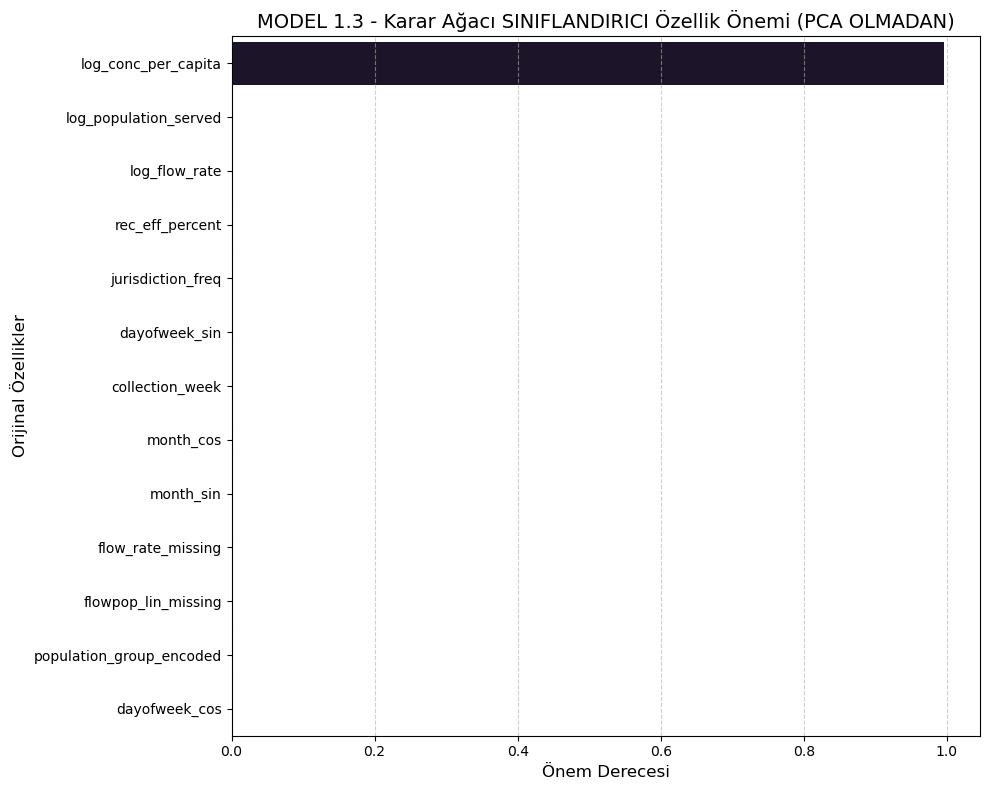

In [7]:
# BÖLÜM 6: SINIFLANDIRMA MODELİ 1.3 (PCA OLMADAN - KARŞILAŞTIRMA)
print("\n--- MODEL 1.3 SONUÇLARI (Karar Ağacı Sınıflandırıcısı - ORİJİNAL ÖZELLİKLER ile) ---")
print("NOT: Bu model, PCA'dan önceki durumu görmek için PCA UYGULANMAMIŞ verilerle eğitilmiştir.")


model_dt_clf_original = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model_dt_clf_original.fit(X_train_clf_scaled, y_train_clf)
y_pred_dt_clf_original = model_dt_clf_original.predict(X_test_clf_scaled) 

print(f"Model Doğruluğu (Accuracy): {accuracy_score(y_test_clf, y_pred_dt_clf_original):.4f}")
print("Sınıflandırma Raporu:\n", classification_report(y_test_clf, y_pred_dt_clf_original, target_names=['Grip Yok (0)', 'Grip Var (1)']))

print("\nAdım (Grafik): Karar Ağacı Sınıflandırıcı (Orijinal) Özellik Önemi gösteriliyor...")
feature_importances_dt_original = model_dt_clf_original.feature_importances_
importance_df_dt_original = pd.DataFrame({
    'Feature': features, 
    'Importance': feature_importances_dt_original
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', y='Feature', data=importance_df_dt_original,
    palette='rocket', 
    hue='Feature', legend=False
)
plt.title('MODEL 1.3 - Karar Ağacı SINIFLANDIRICI Özellik Önemi (PCA OLMADAN)', fontsize=14)
plt.xlabel('Önem Derecesi', fontsize=12)
plt.ylabel('Orijinal Özellikler', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


--- BÖLÜM 2: REGRESYON MODELİ EĞİTİMİNE BAŞLANIYOR ---

Adım (PCA - Regresyon): Ana Bileşen Analizi uygulanıyor...
PCA (Regresyon) 13 adet orijinal özelliği 9 adet ana bileşene indirdi.

--- MODEL 2.1 SONUÇLARI (SGD Regresörü - PCA ile) ---
Model R-Kare (R²) Skoru: 0.9887
Model Kök Hata Kareler Ortalaması (RMSE): 0.4946

--- MODEL 2.2 SONUÇLARI (Karar Ağacı Regresörü - PCA ile) ---
Model R-Kare (R²) Skoru: 0.9916
Model Kök Hata Kareler Ortalaması (RMSE): 0.4267

--- PCA Bileşenlerinin Yorumlanması (Regresyon Modeli 2.2) ---
Grafikteki 'Ana Bileşenlerin' (PC) hangi orijinal özellikleri temsil ettiğini gösteren ana yükler (loadings):

Ana Bileşen 1:
  En çok etkileyen 3 özellik: ['log_population_served', 'population_group_encoded', 'log_flow_rate']

Ana Bileşen 2:
  En çok etkileyen 3 özellik: ['month_sin', 'collection_week', 'log_conc_per_capita']

Ana Bileşen 3:
  En çok etkileyen 3 özellik: ['rec_eff_percent', 'flow_rate_missing', 'log_flow_rate']

Ana Bileşen 4:
  En çok etkileyen 3

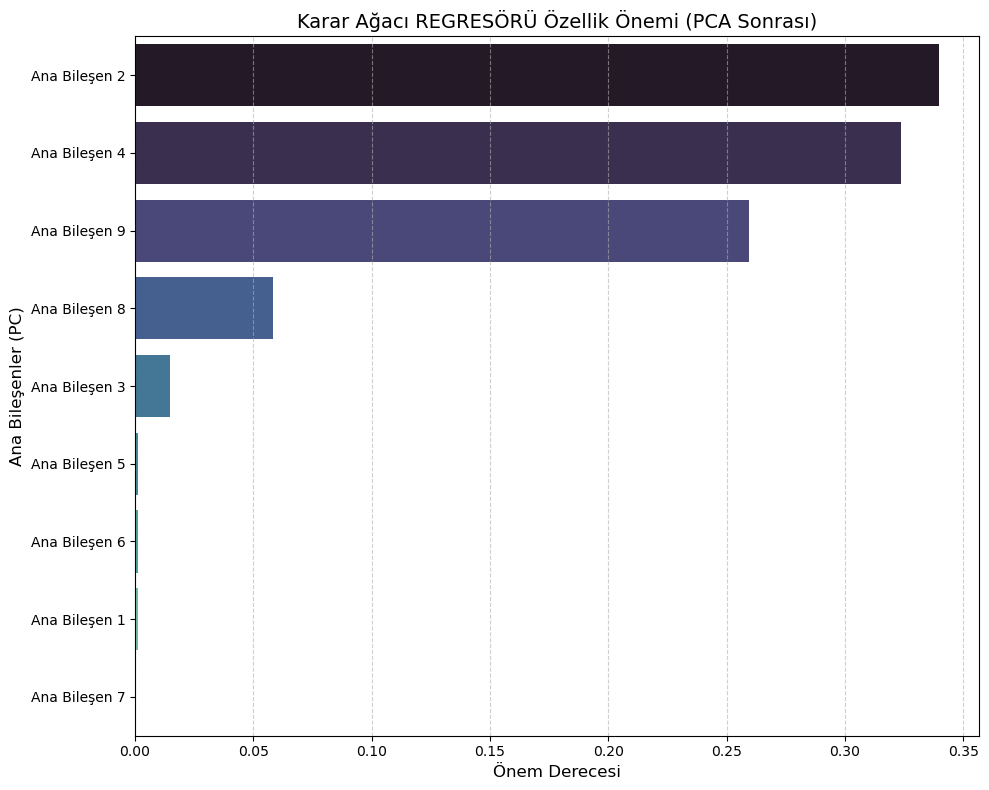


--- MODEL 2.3 SONUÇLARI (Karar Ağacı Regresörü - ORİJİNAL ÖZELLİKLER ile) ---
NOT: Bu model, PCA'dan önceki durumu görmek için PCA UYGULANMAMIŞ verilerle eğitilmiştir.
Model R-Kare (R²) Skoru: 1.0000
Model Kök Hata Kareler Ortalaması (RMSE): 0.0328

Adım (Grafik): Karar Ağacı Regresörü (Orijinal) Özellik Önemi gösteriliyor...


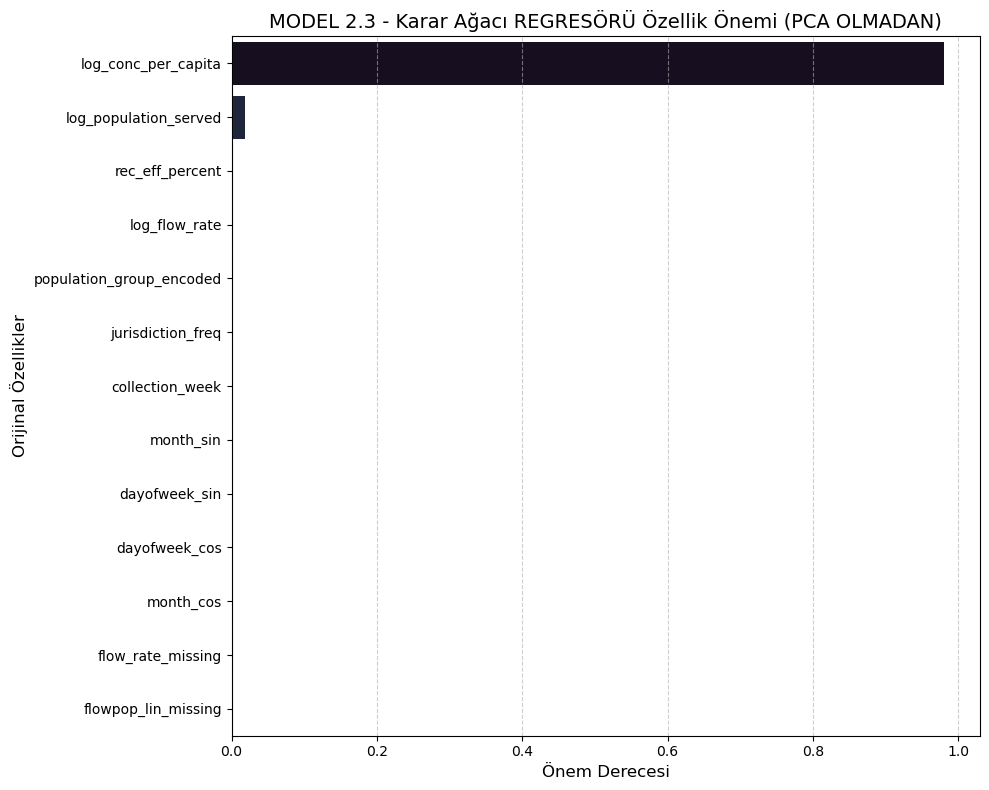


!!! Veri Bilimi Projesi (Vize) Başarıyla Tamamlandı (PCA, 2 Sınıflandırma [SGD, DT] ve 2 Regresyon [SGD, DT] Modeli Dahil) !!!
--- YENİ EKLENENLER: Model 1.3 ve 2.3 (Orijinal Özellik Önemleri) ---


In [8]:
# BÖLÜM 7: REGRESYON MODELLERİ (PCA İLE VE PCA OLMADAN)
print("\n--- BÖLÜM 2: REGRESYON MODELİ EĞİTİMİNE BAŞLANIYOR ---")
y_reg = df_model['log_pcr_target_conc']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print("\nAdım (PCA - Regresyon): Ana Bileşen Analizi uygulanıyor...")
pca_reg = PCA(n_components=0.95, random_state=42)
X_train_reg_pca = pca_reg.fit_transform(X_train_reg_scaled)
X_test_reg_pca = pca_reg.transform(X_test_reg_scaled)
print(f"PCA (Regresyon) {X_train_reg_scaled.shape[1]} adet orijinal özelliği {pca_reg.n_components_} adet ana bileşene indirdi.")


print("\n--- MODEL 2.1 SONUÇLARI (SGD Regresörü - PCA ile) ---")
model_sgd_reg = SGDRegressor(random_state=60) 
model_sgd_reg.fit(X_train_reg_pca, y_train_reg)
y_pred_sgd_reg = model_sgd_reg.predict(X_test_reg_pca)

mse_sgd_reg = mean_squared_error(y_test_reg, y_pred_sgd_reg)
r2_sgd_reg = r2_score(y_test_reg, y_pred_sgd_reg)

print(f"Model R-Kare (R²) Skoru: {r2_sgd_reg:.4f}")
print(f"Model Kök Hata Kareler Ortalaması (RMSE): {np.sqrt(mse_sgd_reg):.4f}")


print("\n--- MODEL 2.2 SONUÇLARI (Karar Ağacı Regresörü - PCA ile) ---")
model_dtr = DecisionTreeRegressor(random_state=42)
model_dtr.fit(X_train_reg_pca, y_train_reg)
y_pred_dtr = model_dtr.predict(X_test_reg_pca)

mse_dtr = mean_squared_error(y_test_reg, y_pred_dtr)
r2_dtr = r2_score(y_test_reg, y_pred_dtr)

print(f"Model R-Kare (R²) Skoru: {r2_dtr:.4f}")
print(f"Model Kök Hata Kareler Ortalaması (RMSE): {np.sqrt(mse_dtr):.4f}")


# Karar Ağacı Regresörü Özellik Önemi Grafiği (PCA ile)
feature_names_reg_pca = [f'Ana Bileşen {i+1}' for i in range(pca_reg.n_components_)]


#PCA Bileşen Yorumlaması (Regresyon) 
print("\n--- PCA Bileşenlerinin Yorumlanması (Regresyon Modeli 2.2) ---")
print("Grafikteki 'Ana Bileşenlerin' (PC) hangi orijinal özellikleri temsil ettiğini gösteren ana yükler (loadings):")
loadings_reg = pca_reg.components_

for i, component in enumerate(feature_names_reg_pca):
    weights = loadings_reg[i]
    feature_weights = pd.Series(weights, index=features)
    # Mutlak değere göre sırala
    sorted_weights = feature_weights.abs().sort_values(ascending=False)
    # En yüksek 3 özelliği al
    top_features = sorted_weights.head(3).index
    
    print(f"\n{component}:")
    print(f"  En çok etkileyen 3 özellik: {list(top_features)}")
print("----------------------------------------------------------")



feature_importances_dtr = model_dtr.feature_importances_
importance_df_dtr = pd.DataFrame({
    'Feature': feature_names_reg_pca,
    'Importance': feature_importances_dtr
}).sort_values(by='Importance', ascending=False)

top_features_dtr = importance_df_dtr.head(pca_reg.n_components_)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', y='Feature', data=top_features_dtr,
    palette='mako',
    hue='Feature', legend=False
)
plt.title('Karar Ağacı REGRESÖRÜ Özellik Önemi (PCA Sonrası)', fontsize=14)
plt.xlabel('Önem Derecesi', fontsize=12)
plt.ylabel('Ana Bileşenler (PC)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



print("\n--- MODEL 2.3 SONUÇLARI (Karar Ağacı Regresörü - ORİJİNAL ÖZELLİKLER ile) ---")
print("NOT: Bu model, PCA'dan önceki durumu görmek için PCA UYGULANMAMIŞ verilerle eğitilmiştir.")


model_dtr_original = DecisionTreeRegressor(random_state=42)
model_dtr_original.fit(X_train_reg_scaled, y_train_reg) # <-- _scaled, _pca DEĞİL
y_pred_dtr_original = model_dtr_original.predict(X_test_reg_scaled) # <-- _scaled, _pca DEĞİL

mse_dtr_original = mean_squared_error(y_test_reg, y_pred_dtr_original)
r2_dtr_original = r2_score(y_test_reg, y_pred_dtr_original)

print(f"Model R-Kare (R²) Skoru: {r2_dtr_original:.4f}")
print(f"Model Kök Hata Kareler Ortalaması (RMSE): {np.sqrt(mse_dtr_original):.4f}")

print("\nAdım (Grafik): Karar Ağacı Regresörü (Orijinal) Özellik Önemi gösteriliyor...")
feature_importances_dtr_original = model_dtr_original.feature_importances_
importance_df_dtr_original = pd.DataFrame({
    'Feature': features, # <-- Orijinal 'features' listesi
    'Importance': feature_importances_dtr_original
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', y='Feature', data=importance_df_dtr_original,
    palette='cubehelix', # Farklı bir palet
    hue='Feature', legend=False
)
plt.title('MODEL 2.3 - Karar Ağacı REGRESÖRÜ Özellik Önemi (PCA OLMADAN)', fontsize=14)
plt.xlabel('Önem Derecesi', fontsize=12)
plt.ylabel('Orijinal Özellikler', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



print("\n!!! Veri Bilimi Projesi (Vize) Başarıyla Tamamlandı (PCA, 2 Sınıflandırma [SGD, DT] ve 2 Regresyon [SGD, DT] Modeli Dahil) !!!")
print("--- YENİ EKLENENLER: Model 1.3 ve 2.3 (Orijinal Özellik Önemleri) ---")